# Random variable, stochastic process and simulation.

In [101]:
import numpy as np
import scipy 

from numpy.random import normal, choice, uniform

import ipywidgets as widgets
import matplotlib.pyplot as plt
plt.style.use('fast')

%matplotlib inline

## Random numbers, probability distribution and stat analysis

- The [**numpy.random**](https://docs.scipy.org/doc/numpy-1.15.1/reference/routines.random.html) has the fastest random number generators that are based on low level code written in C. 
- The [**Scipy.stats**](https://docs.scipy.org/doc/scipy/reference/stats.html ) has an extensive library of statistical distributions and tools for statistical analysis. 

- The [**Statsmodels**](https://www.statsmodels.org/stable/ ) Enhancing Scipy functionality with more tools
- The [**Seaborn**](https://docs.pymc.io/) library that enhances matplotlib functionality for stat visualization.  

## General overview of random numbers in python 

First we take a look at most widely used random numbers of numpy also called standard random numbers. These are rand (uniform random number on interval 0,1) and randn (stnadard normal random number with 0 mean and 1 variance). 

- When running code that uses random numbers results will always be different for every run. If you want code to reproduce same result you can fix the seed to get reproducible results: ```np.random.seed(8376743)```

$$f(x)=\begin{cases}
{\frac {1}{b-a}}&\mathrm {for} \ a\leq x\leq b,\\[8pt]0&\mathrm {for} \ x<a\ \mathrm {or} \ x>b
\end{cases}
$$

In [2]:
# Generates standard uniform random numbers U(0,1)
r = np.random.rand(10) 

r

array([0.14844069, 0.78110037, 0.17294069, 0.49010182, 0.56340324,
       0.9799353 , 0.84345523, 0.18753032, 0.8023181 , 0.62587149])

In [44]:
def rnplot(r):
    '''Convenience function for making quick two panel plot showing 
    a line plot for the sequece of random numbers (RN)
    a histogram plot of probability density of random numbers 
    '''
    
    fig, ax = plt.subplots(ncols=2) 

    ax[0].plot(r,  color='blue', label='trajectory')
    ax[1].hist(r,  density=True, color='red',  label = 'histogram')
    
    
    ax[0].set_xlabel('Samples of RN')
    ax[0].set_ylabel('Values of RN')
    
    ax[1].set_xlabel('Values of RN')
    ax[1].set_ylabel('Probability Density')

    fig.legend();
    fig.tight_layout()

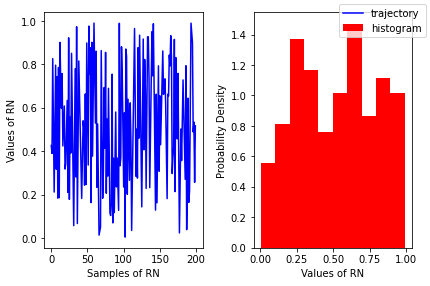

In [45]:
r = np.random.rand(200) 
rnplot(r)

In the same way we generate and visualize norally distributed random numbers, $N(0,1)$

$$P(x |\mu=0, \sigma=1) = \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

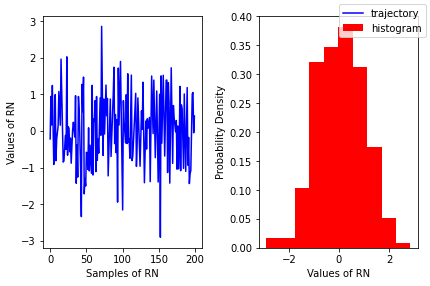

In [46]:
r = np.random.randn(200) 

rnplot(r)

- We showed examples of standard random numbers $U(0,1)$ and $N(0,1)$

- Parametraized random number allow you to set parameters like value of mean and interval length and therefore can be viewed as generalized versions of standard random numbers. Below we take a look at examples of continuous (random and unofrm RVs) and discrete random numbers generated by paratmerized distributions. 

(5, 200)


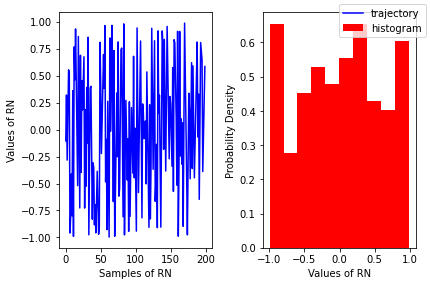

In [53]:
r = np.random.uniform(low=-1, high=1, size=(5, 200))
print(r.shape)
rnplot(r[0,:])


(2, 2000)


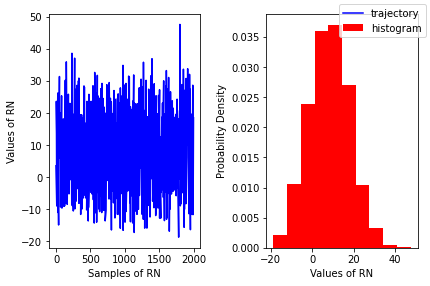

In [61]:
r=np.random.normal(loc=8, scale=10, size=(2, 2000))
print(r.shape)
rnplot(r[0,:])

(2000,)


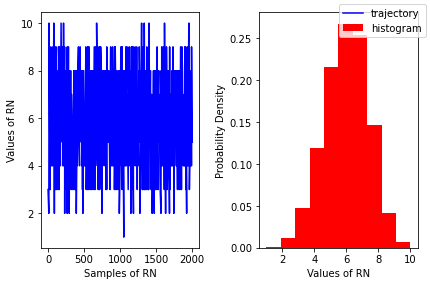

In [59]:
r = np.random.binomial(n=10, p=0.6, size=2000) 

print(r.shape)
rnplot(r)

### Using random numbers to get answers via simulations 

One of the major uses of random numbers is for conducting numerical simulations. What is a simulation? It is a recreation of a process on a computer. And this recreation is done by random numbers. E.g to simulate coint tosses, die throws, diffusion of molecules, conformational change of polymers we use random number to recreate the process on a computer. Let's start off by asking some simple questions

- How often do we get a run of 5 or more consecutive heads in 100 coin tosses if we repeat the experiment 1000 times?
<br>
- What if the coin is biased to generate heads only 40% of the time?

We will use ```np.random.choice``` which generates random samples from limited options. 

```python
np.random.choice(a, size, p, replace=True)
```
- ```a:``` an array/list of choices like, ```[-1, 1]``` or ```[1, 2, 3]``` or ```['bagel', 'muffin']```
- ```p:``` probabilities of picking choices from a. E.g ```p=[0.5, 0.5]```. Default is equal probabilities.
- ```size:``` shape of an array could be ```N, (N,M), (N,M,Q)``` etc
- ```replace=True.``` If you choose bagel from a, the caffee will put back a new one on shelf.

In [65]:
L = 100    # length of each trajectory
N = 1      # number of experiments: stochastic trajecotries generated

xs = np.random.choice([0,1], size=(L, N)) # (i) Unbiased coin p=[0.5,0.5] by default

ys = np.random.choice([0,1], size=(L, N), p=[0.9, 0.1])  # (ii) biased coin

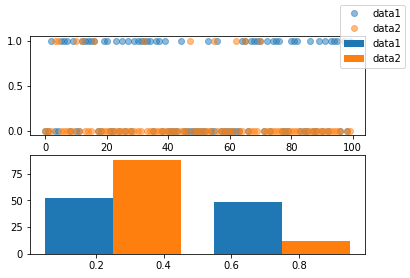

In [66]:
fig, ax = plt.subplots(nrows=2)

r = np.random.randn(200) 

ax[0].plot(xs, 'o', alpha=0.5, label  =  'data1')
ax[0].plot(ys, 'o', alpha=0.5, label =  'data2')

ax[1].hist((xs[:,0], ys[:,0]), 2, label = ("data1", "data2"))

fig.legend();

### Simulating a 1D unbiased random walk 

- Random walker will be modeled by a random variable $x_t$ which is taking on +1 or -1 values at different times or instances t. 
- We will be tracking the net displacement of a random walker, in other words the cumulative sum of walks:

$$Z_N = \sum^{t=N}_{t=0} x_i$$

- We will be interested in computing probability distribution of $P(z=Z_N)$ and its various moments.
- To do so we need many independent random walkers to obtain good statistics on $Z_N$ distribution! 

**Independent observations (trajectories) of random walkers**

In the course of simulating random walks we will be generating multidimensional numpy arrays. We will adhere to a convention that:

- **Rows** are regarded as number of measurements, or **samples**
- **Columns** are regarded as number of observables **distinct measurements/trajectories**
- We then take **cumulative sum  over trajectory** [a,b,c,...], which accumulates random walker's position over time [a, a+b, a+b+c,...]. This is done by convenient ```np.cumsum()``` method.

In [67]:
def rw_1d(L, N):
    '''
    L: trajectory length
    N: Number of trajecotry
    returns np.array (L, N) shape 
    '''
    
    # Create random walks 
    r  = choice([-1,1], size=(L, N))
    
    #Accumulate position
    rw = r.cumsum(axis=0)

    #Set initial position 
    rw[0,:]=0 
    
    return rw

In [68]:
rw = rw_1d(2000, 1000)

print(rw.shape)
L = rw.shape[0]
N = rw.shape[1]

(2000, 1000)


In [122]:
# Simulate 1D random walk
Tmax = 1000
N    = 1000 
rw   = rw_1d(Tmax, N)

@widgets.interact(t=(1, Tmax-1))
def rw_plotter(t=1):
    
    fig, ax = plt.subplots(nrows=2)

    ax[0].plot(rw)
    ax[0].axvline(x=t, color='black', linestyle='-', lw=2)
    ax[1].hist(rw[t, :], color='orange', density=True, label=f'time={t}')

    ## Plot gaussian with width t**0.5
    x = np.linspace(-100,100, 1000)
    y = scipy.stats.norm.pdf(x, 0, np.sqrt(t))
    ax[1].plot(x,y, color='black', lw=2, label=f'std={np.sqrt(t):.2f}')  

    ax[0].set_ylabel('Position')
    ax[0].set_title('RW trajectries');

    ax[1].set_xlabel('Position')
    ax[1].set_ylabel('Histogram')
    ax[1].set_xlim([-100, 100])
    ax[1].legend()
    fig.tight_layout()

interactive(children=(IntSlider(value=1, description='t', max=999, min=1), Output()), _dom_classes=('widget-in…

**Exercise**

- Show that if instead of measuring raw sum of random walker positions we measured sum divided by the standard deviation then distribution will converging to standard normal, $P(z=Z_n)\sim N(0,1)$

$$Z_N(t) = \frac{1}{\sqrt{N}}\sum^{i=N}_{i=0} x_i$$

- What if we measure the average of radnom walker's positions? 

$$Z_N(t) = \frac{1}{N}\sum^{i=N}_{i=0} x_i$$

### Connection with diffusion: Mean square displacement 


$$
\langle Z(t)^2 \rangle^{1/2} = \frac{1}{n}\sum_{trajectories} Z_n(t)^2  \sim t^{1/2}
$$

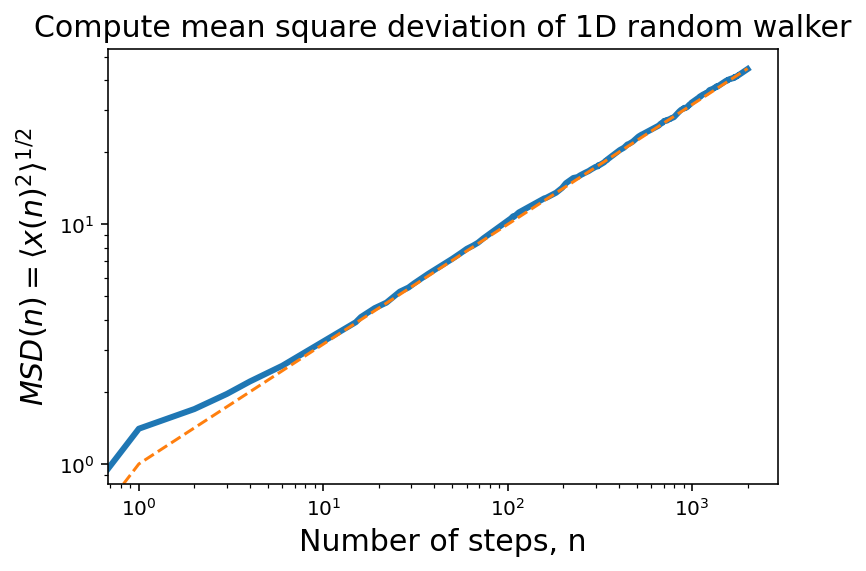

In [186]:
L, N = 2000, 1000
rw = rw_1d(L, N)

t = np.arange(L)
msd = np.mean(rw**2, axis=1)
rsd = msd**0.5

plt.loglog(np.arange(L), rsd, lw=3) 

plt.loglog(t, np.sqrt(t), '--')

plt.title('Compute mean square deviation of 1D random walker',fontsize=15)
plt.xlabel('Number of steps, n',fontsize=15)
plt.ylabel(r'$MSD(n)=\langle x(n)^2 \rangle^{1/2}$',fontsize=15);

**Questions**
- Compute MSD for 1D random walk show the expected scaling 
- Generate random walks from different positions
- choice between [-1,1] 
- Multinomial choice
- Self avoiding walks

In [176]:
def rw_2d(L, N):
    
    '''2d random walk function:
    L: trajectory length
    N: Number of trajecotry
    returns np.array with shape (L, N)
    '''
    verteces = np.array([(1,  0),
                         (0,  1),
                         (-1, 0),
                         (0, -1)])
    
    rw       = verteces[choice([0,1,2,3], size=(L, N))]
    
    rw[0, :, :] = 0
    
    return rw.cumsum(axis=0)

In [178]:
traj = rw_2d(L=10000, N=1000)

In [179]:
print(traj.shape)

(10000, 1000, 2)


**Compute room mean square distance of a random walker**

$$
\langle R(t)^2 \rangle^{1/2} = \langle (X(t)^2+Y(t)^2)\rangle^{1/2} \sim t^{1/2}
$$

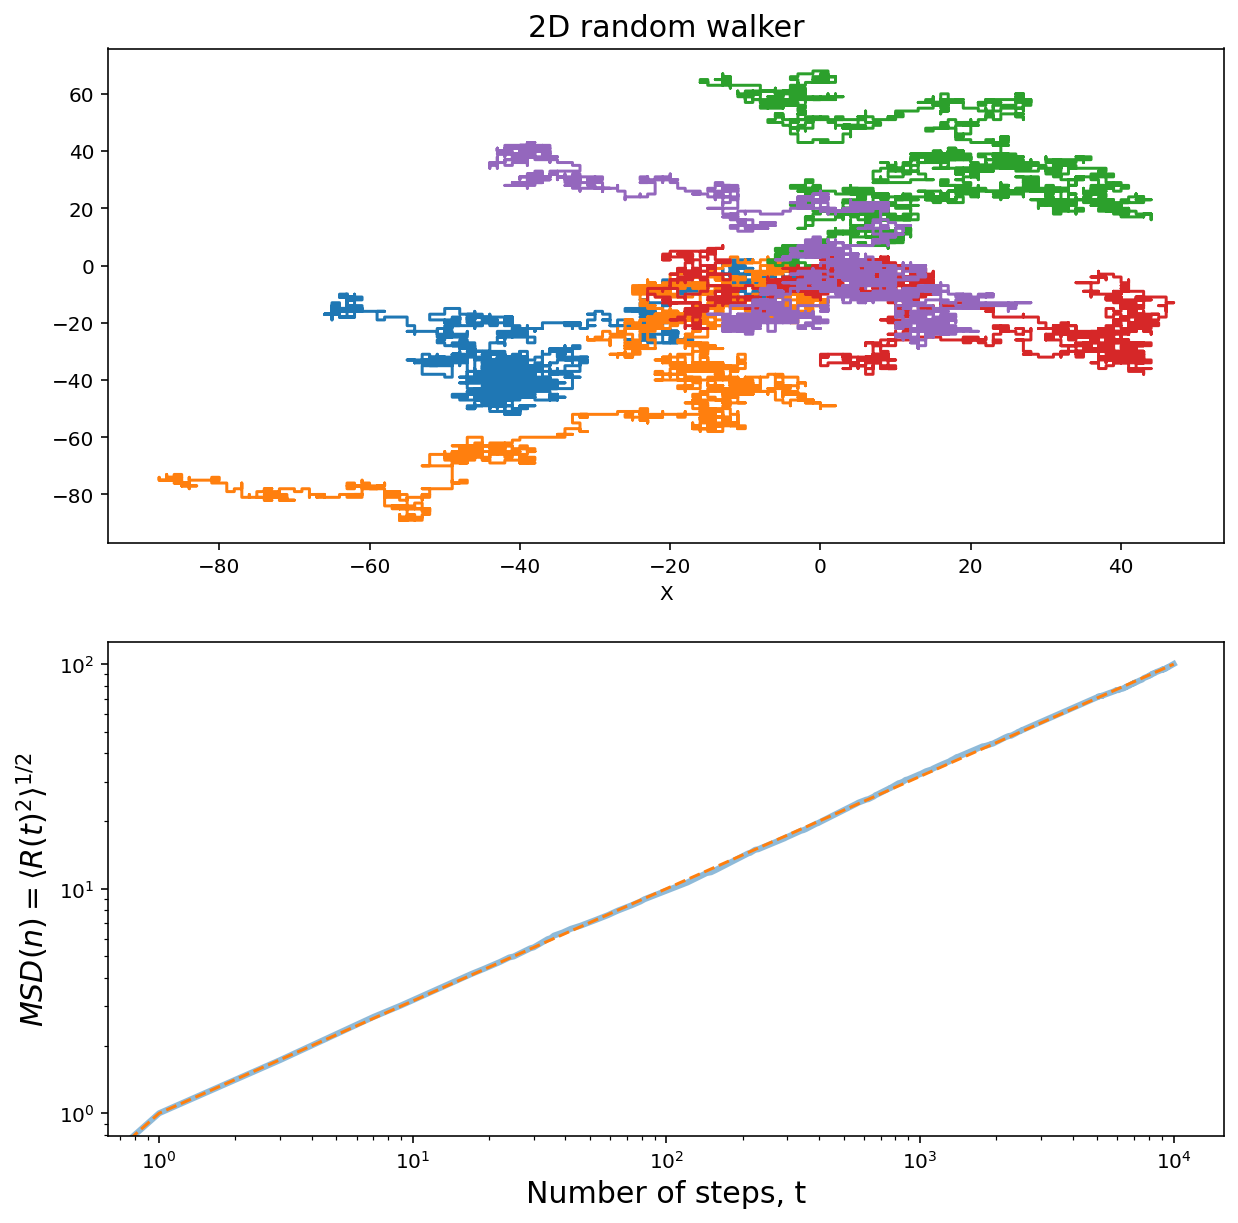

In [195]:
fig, ax  = plt.subplots(nrows=2, figsize=(10,10))

#Simulate 2D random walk
L, N = 10000, 1000
traj = rw_2d(L, N)

#Compute RSD 
t            = np.arange(L)
r2           = np.sum(traj**2, axis=2)
mean_r2      = np.mean(r2, axis = 1)
rsd          = np.sqrt(mean_r2)

ax[0].plot(traj[:3000, :5, 0], traj[:3000, :5, 1]);

ax[1].loglog(t, rsd, lw=3, alpha=0.5);
ax[1].loglog(t, t**0.5, '--');

ax[0].set_title('2D random walker',fontsize=15)
ax[0].set_xlabel('X')
ax[1].set_xlabel('Y')

ax[1].set_xlabel('Number of steps, t',fontsize=15)
ax[1].set_ylabel(r'$MSD(n)=\langle R(t)^2 \rangle^{1/2}$',fontsize=15);

### Probability distributions of a random walker

- So far we have mostly simulated random walk pretending that we do not know which porbability distributions the walk was governed.  

- Below we illustrate a few example uses of ```scipy.stats``` library which contains probability distribution functions.
- Moreover ```scipy.stats``` also has convenience reference to the same numpy random numbers that we have generated above. 

In [124]:
from scipy.stats import binom, norm, poisson  

In [139]:
s =  binom(n=10, p=0.5) # Let us declare s to be a binomial RV

In [88]:
print(s.rvs(20))          # 20 random samples form X
print(s.pmf(5))           # P(X = 5)
print(s.cdf(5))           # P(X <= 5)
print(s.mean())           # E[X], mean
print(s.var())            # Var(X), variance
print(s.std())            # Std(X), standard deviation

[6 2 7 7 6 5 7 4 4 4 5 4 3 3 4 5 6 5 3 6]
0.24609375000000003
0.623046875
5.0
2.5
1.5811388300841898


Continuous probability distributions are defined similarily with methods for generating random variables and distributions.

In [214]:
def coin_flip(p,N):
    '''
    N: flip coint N times taking on values 0 or 1 
    p: with p probability
    ''' 
    # Binomial
    b       = binom(N, p) 
    
    #Gaussian       
    g = norm(N*p, (N*p*p)**0.5) #loc=mu, scale=sigma
    
    #Poisson
    p = poisson(N*p)
        
    fig, ax=plt.subplots(nrows=2, ncols=1)
    
    # Plot values of coin flips and histogram
    ax[0].plot(b.rvs(N), '-',color='grey')
    ax[1].hist(b.rvs(N),  density=True)
    
    # Possible values of a coin to plot dists
    vals    = np.arange(N) 
    
    ax[1].plot(b.pmf(vals), '-o', color='black', label='Binom')
    ax[1].plot(g.pdf(vals), color='green', label='Gauss')
    ax[1].plot(p.pmf(vals), color='red', label='Poisson')
    
    #ax[1].set_ylim(0,)
    ax[0].set_ylabel('Coin sum')
    ax[1].set_xlabel('Coin sum')
    ax[1].set_ylabel('Probability dist')
    ax[1].legend()
    fig.tight_layout()

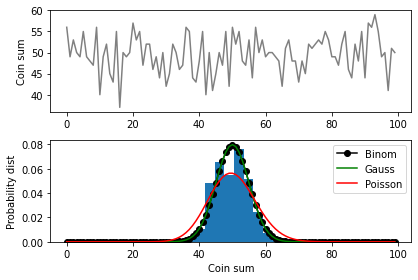

In [221]:
coin_flip(p=0.5, N=100);

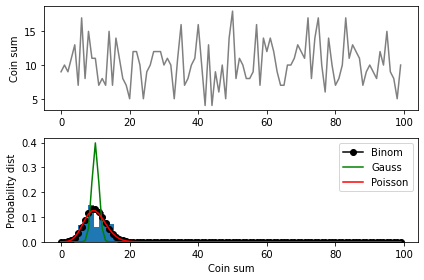

In [222]:
coin_flip(p=0.1, N=100);

### Problems



####  Confined diffusion.
Simulate 2D random walk in a circular confinement. Re-write 2D brownian motion code to simulate diffusion of a particle which is stuck inside a sphere. 
Study how root mean square deviation of position scales with time. Carry out simulations for different coninement sizes. Make plots of simulated trajectories.

####  Continuous time random walk (CTRW)

Simulate 1D random walk but instead of picking times at regular intervals pick them from  exponential distribution. <br>
Hint: you may want to use random variables from scipy.stats.exp <br>

[scipy.stats.expon](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html) <br>

Study the root mean square deviation as a function of exponential decay parameter $\lambda$ of exponential distribution $e^{-\lambda x}$. 

####  Breaking the CLT; Cauchy vs Normal random walk in 2D

For this problem we are going to simulate two kinds of random walks in continuum space (not lattice): Levy flights and Normal distributd random walk. 

To simulate a 2D continuum space random walk we need to generate random step sizes $r_x$, $r_y$. 
Also you will need unifrom random namber to sample angles in 2D giving you a conitnuum random walk in 2D space: $x = r_x sin\theta$ and $y=r_ycos\theta$

- Normally: $r\sim N(0,1)$
- Cauchy distribution (long tails, infinite variance) $r\sim Cauchy(0,1)$
- Unform angles $\theta \sim U(0,1)$

Visualize random walk using matplotlib and study statistics of random walkers the way that is done for normal random walk/brownian motion examples!

## References

**The mighty little books**
-  ["Random Walks in Biology",  H Berg (1993)](https://www.amazon.com/Random-Walks-Biology-Howard-Berg/dp/0691000646)
-  ["Physical models of Living systems",  P Nelson (2015)](https://www.amazon.com/gp/product/1464140294/ref=ppx_yo_dt_b_search_asin_title?ie=UTF8&psc=1)

**More in depth**
 
 - ["Simple Brownian Diffusion: An Introduction to the Standard Theoretical Models", D Gillespie](https://www.amazon.com/Simple-Brownian-Diffusion-Introduction-Theoretical/dp/0199664501/ref=sr_1_1?keywords=diffusion+brownian&qid=1579882520&sr=8-1)
- 
 - ["Stochastic Processes for Physicists" K Jacobs](https://www.amazon.com/Stochastic-Processes-Physicists-Understanding-Systems/dp/0521765420/ref=sr_1_1?keywords=kurt+jacobs+stochastic&qid=1579882738&sr=8-1)
 
**On the applied side**
- [Brownian Motion: Elements of Colloid Dynamics A P Philipse (2018)](https://www.amazon.com/Brownian-Motion-Elements-Dynamics-Undergraduate/dp/3319980521/ref=sr_1_7?keywords=einstein+brownian&qid=1579882356&sr=8-7)